# Step 5: Recommender System

To implement the image recommendation functionality for our project, we are following these steps:

1. Image Classification: Utilize our existing machine learning model to classify the user-provided reference image into one of the eight flower classes.
2. Similarity Detection:
    - Construct a Convolutional Neural Network (CNN) to extract feature vectors from images
    - For each image in our database use this CNN to extract its feature vector, then store it in `./data/recommender-database.csv`, to allow for efficient retrieval during the recommendation process.
    - Use the same CNN to extract a feature vector from our the user-provided reference image.
    - Apply a K-Means unsupervised machine learning model to cluster the reference image's feature vector with those of the images in our database. We select the number of cluster $k$ dynamically using the number of images need to be recommended.
3. Recommending Images: Once we have the clusters, we would recommend images from the cluster that the reference image belongs to. To do this accurately, we are using [Scikit-learn implementation of cosine similarity](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html) to find the most similar images to the reference image within that cluster.

In [1]:
# Imports and environmental setups

import os, sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from tqdm.auto import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image


# Custom utils functions
from utils import dataset
from utils import data_manip as manip
from utils.glob import TARGET_IMG_SIZE


# Reproducible results
np.random.seed(42)
tf.random.set_seed(42)

# Misc.
plt.style.use('ggplot')
dir_recommender_database = '../data/recommender-database/'
path_recommender_database = '../data/recommender-database.csv'
dir_models = '../models/'

model_fv_extractor_name = 'fv-extract'
dir_log_fv_extractor = '../log/' + model_fv_extractor_name
path_model_fv_extractor = dir_models + model_fv_extractor_name


# Environment information
print("TF version:", tf.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.12.0
GPU is NOT AVAILABLE


## 5.1. Feature Extractor - CNN

In [2]:
# Model Parameters
INPUT_DIM = (TARGET_IMG_SIZE, TARGET_IMG_SIZE, 3)  # RGB - 3 channels images
FEATURE_VEC_DIM = 16

In [3]:
fv_extractor = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (4, 4), activation='relu', input_shape=INPUT_DIM),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (4, 4), activation='relu'),
    tf.keras.layers.AveragePooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(FEATURE_VEC_DIM),
], name=model_fv_extractor_name)

fv_extractor.compile(optimizer='adam', loss='mse')

In [4]:
fv_extractor.summary()

Model: "fv-extract"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 253, 253, 32)      1568      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 126, 126, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 123, 123, 64)      32832     
                                                                 
 average_pooling2d (AverageP  (None, 61, 61, 64)       0         
 ooling2D)                                                       
                                                                 
 flatten (Flatten)           (None, 238144)            0         
                                                                 
 dense (Dense)               (None, 128)               3

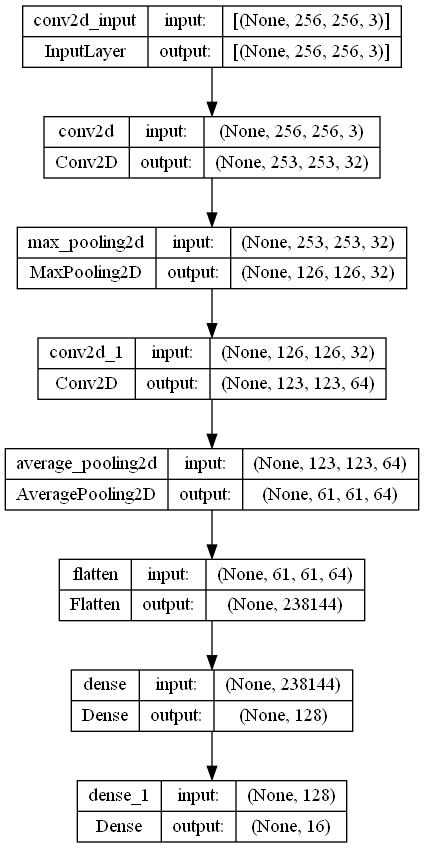

In [5]:
tf.keras.utils.plot_model(fv_extractor, show_shapes=True, to_file=f'images/{model_fv_extractor_name}-Diagram.png')

## 5.1. Recommender Database: Feature Extraction

- Load all image in `./data/recommender-database/`.
- Extract their feature vectors using our feature extractor defined above.
- Save them in `./data/recommender-database.csv`

In [6]:
feature_vectors = {'ImgPath': []}
for j in range(FEATURE_VEC_DIM):
    feature_vectors[f'x{j}'] = []

In [7]:
df = dataset.load(dir_recommender_database)
print(f'Number of images in database: {df.shape[0]}')

Number of images in database: 4685


In [8]:
with tqdm(total=len(df), desc='Extracting image feature vectors', position=0, leave=True) as pbar:
    for i, row in df.iterrows():
        pbar.update()
        feature_vectors['ImgPath'].append(row['ImgPath'])
        with Image.open(f'{dir_recommender_database}{feature_vectors["ImgPath"][-1]}') as im:
            im_processed = manip.resize_crop(im, TARGET_IMG_SIZE, TARGET_IMG_SIZE)
            im_processed = manip.normalize_pixels(im_processed)
            im_processed = tf.expand_dims(im_processed, axis=0)

            feature_vector = fv_extractor.predict(im_processed, verbose=1)
            for j, feature in enumerate(feature_vector.reshape(-1)):
                feature_vectors[f'x{j}'].append(feature)

Extracting image feature vectors:   0%|          | 0/4685 [00:00<?, ?it/s]

1/1 [==============================] - 0s 44ms/step


In [9]:
df_feature_vectors = pd.DataFrame(feature_vectors)
df_feature_vectors.to_csv(path_recommender_database)